<a href="https://colab.research.google.com/github/robonesky/oreilly/blob/main/RM%20Lab%20Notes%2011%20202301%20cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_val_score
)

from xgboost import  XGBClassifier, plot_importance, to_graphviz

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    auc
)

from sklearn.metrics import (
    classification_report,
    confusion_matrix
)

In [5]:
df = pd.read_csv('./spy.csv', index_col=0, parse_dates = True)[['Adj Close']]
df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()
df.head()

,Adj Close,Returns,Ret_1M
Date,,,
1996-05-08,41.272911,NaN,NaN
1996-05-09,41.243053,-0.000724,NaN
1996-05-10,41.651173,0.009847,NaN
1996-05-13,42.278339,0.014945,NaN
1996-05-14,42.537167,0.006103,NaN


In [6]:
df.describe()

,Adj Close,Returns,Ret_1M
count,6293.000000,6292.000000,6273.000000
mean,133.292492,0.000370,0.007261
std,79.402662,0.012427,0.047793
min,40.130543,-0.115886,-0.370872
25%,80.180862,-0.004807,-0.015076
50%,98.580070,0.000717,0.013592
75%,177.175781,0.006254,0.034639
max,422.119995,0.135577,0.212052


<Axes: >

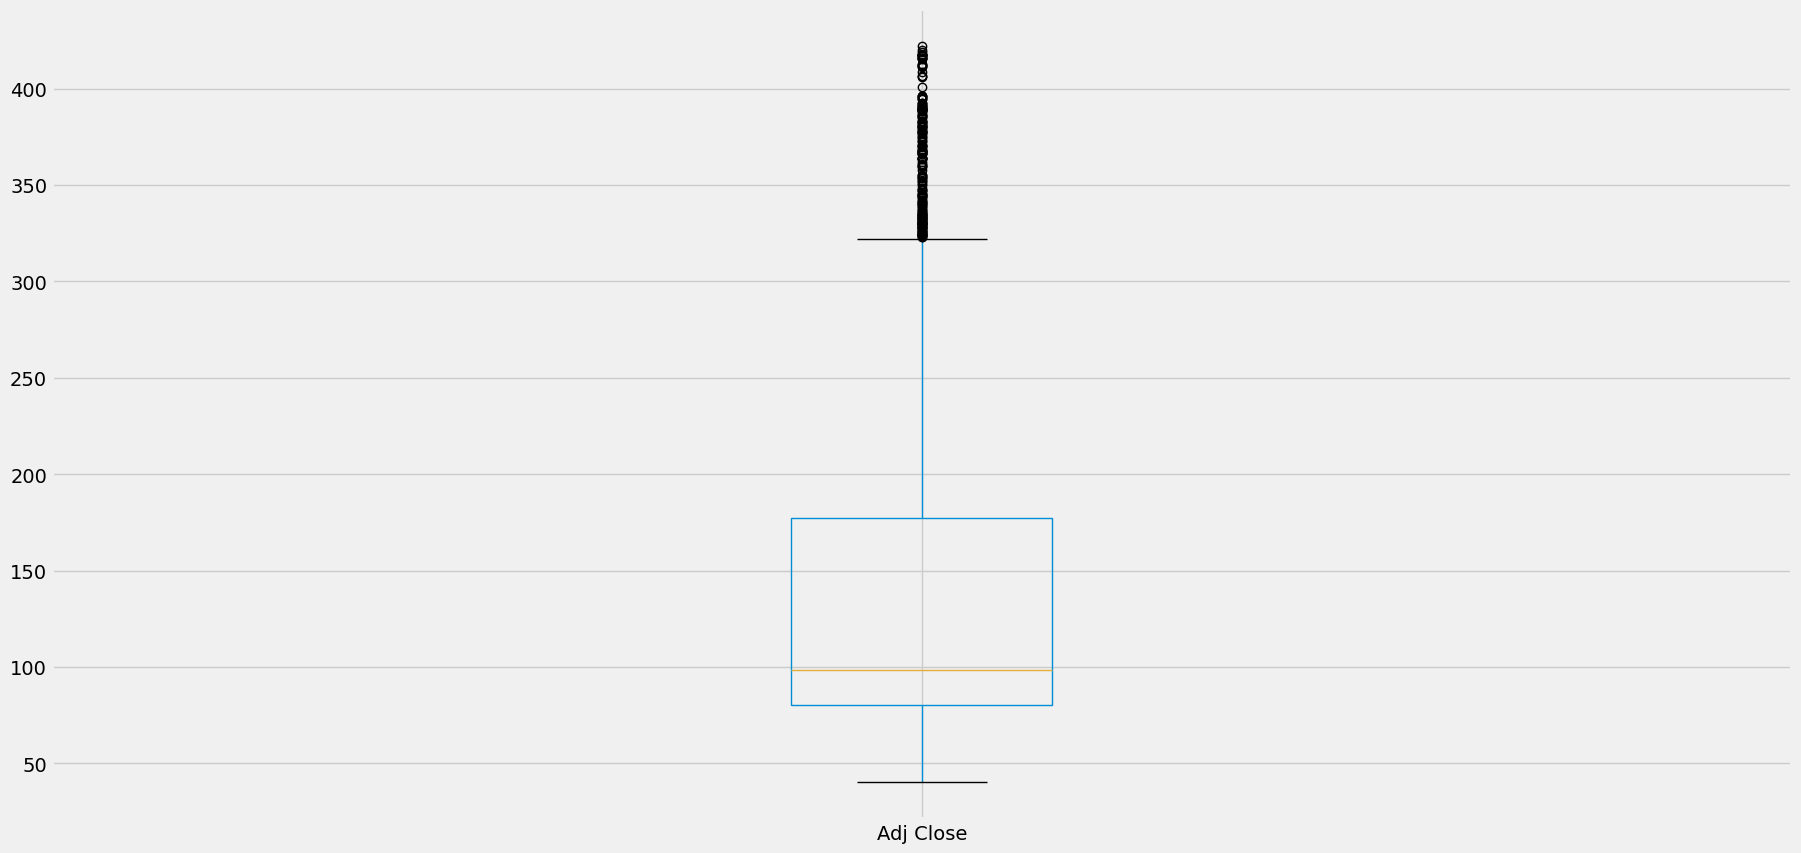

In [9]:
pd.DataFrame(df['Adj Close']).boxplot()

In [10]:
df.isnull().sum() # we have some nulls, as you'd expect

Adj Close     0
Returns       1
Ret_1M       20
dtype: int64

In [12]:
features_list = []
for r in range(10, 65, 5):
  df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
  df['Std_'+str(r)] = df.Returns.rolling(r).std()
  features_list.append('Ret_'+str(r))
  features_list.append('Ret_'+str(r))

df.dropna(inplace=True)


In [13]:
df['Target'] = np.where(
    df['Adj Close'].shift(-1) > 0.995 * df['Adj Close'],
    1,
    0
)

df

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,Std_25,Ret_30,Std_30,Ret_35,Std_35,Ret_40,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-08-02,42.632458,0.021353,0.014899,0.039747,0.011405,0.030508,0.013501,0.014899,0.012707,-0.004684,0.012668,0.004815,0.011782,-0.004526,0.011024,-0.010551,0.010308,-0.006848,0.009987,-0.018835,0.009678,0.003408,0.009394,0.032410,0.009304,0
1996-08-05,42.382282,-0.005885,0.013072,0.041216,0.011251,0.054593,0.010528,0.013072,0.012750,-0.014068,0.012693,-0.009635,0.011722,-0.006219,0.011046,-0.016437,0.010346,-0.005285,0.009964,-0.020588,0.009695,-0.004583,0.009424,0.027248,0.009340,1
1996-08-06,42.512363,0.003065,0.012078,0.057159,0.009580,0.055167,0.010525,0.012078,0.012738,-0.019581,0.012575,-0.008439,0.011731,-0.002454,0.011059,-0.010133,0.010350,-0.005020,0.009966,-0.021427,0.009688,-0.006882,0.009404,0.020465,0.009265,1
1996-08-07,42.622448,0.002586,0.010622,0.057753,0.009556,0.045883,0.010279,0.010622,0.012722,-0.013295,0.012577,-0.004685,0.011742,0.008342,0.010975,-0.006619,0.010359,-0.009399,0.009916,-0.008705,0.009594,-0.011018,0.009365,0.008106,0.009070,1
1996-08-08,42.552395,-0.001645,0.029354,0.047192,0.009752,0.030566,0.009903,0.029354,0.011754,-0.012852,0.012575,0.000470,0.011679,0.002232,0.010955,-0.006406,0.010358,-0.019798,0.009823,-0.003612,0.009550,-0.011276,0.009366,0.000358,0.009039,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,418.200012,0.002154,0.028720,0.007175,0.006920,0.015811,0.006489,0.028720,0.005811,0.054596,0.006143,0.071147,0.006682,0.062727,0.006899,0.089551,0.006976,0.098112,0.008508,0.073006,0.009142,0.071264,0.008772,0.082900,0.008441,0
2021-05-04,415.619995,-0.006188,0.023123,0.008335,0.006778,0.006663,0.006723,0.023123,0.006044,0.048913,0.006349,0.057006,0.006773,0.050592,0.006988,0.088354,0.007010,0.067972,0.007921,0.074539,0.009113,0.060148,0.008815,0.072784,0.008490,1
2021-05-05,415.750000,0.000313,0.022279,-0.000769,0.006071,0.010397,0.006638,0.022279,0.006047,0.051882,0.006286,0.065220,0.006525,0.052167,0.006975,0.074490,0.006741,0.076119,0.007795,0.073638,0.009114,0.061327,0.008812,0.065900,0.008454,1


In [16]:
X = df.drop(['Adj Close', 'Returns', 'Ret_1M', 'Target'], axis=1)
X

,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,Std_25,Ret_30,Std_30,Ret_35,Std_35,Ret_40,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60
Date,,,,,,,,,,,,,,,,,,,,,,
1996-08-02,0.039747,0.011405,0.030508,0.013501,0.014899,0.012707,-0.004684,0.012668,0.004815,0.011782,-0.004526,0.011024,-0.010551,0.010308,-0.006848,0.009987,-0.018835,0.009678,0.003408,0.009394,0.032410,0.009304
1996-08-05,0.041216,0.011251,0.054593,0.010528,0.013072,0.012750,-0.014068,0.012693,-0.009635,0.011722,-0.006219,0.011046,-0.016437,0.010346,-0.005285,0.009964,-0.020588,0.009695,-0.004583,0.009424,0.027248,0.009340
1996-08-06,0.057159,0.009580,0.055167,0.010525,0.012078,0.012738,-0.019581,0.012575,-0.008439,0.011731,-0.002454,0.011059,-0.010133,0.010350,-0.005020,0.009966,-0.021427,0.009688,-0.006882,0.009404,0.020465,0.009265
1996-08-07,0.057753,0.009556,0.045883,0.010279,0.010622,0.012722,-0.013295,0.012577,-0.004685,0.011742,0.008342,0.010975,-0.006619,0.010359,-0.009399,0.009916,-0.008705,0.009594,-0.011018,0.009365,0.008106,0.009070
1996-08-08,0.047192,0.009752,0.030566,0.009903,0.029354,0.011754,-0.012852,0.012575,0.000470,0.011679,0.002232,0.010955,-0.006406,0.010358,-0.019798,0.009823,-0.003612,0.009550,-0.011276,0.009366,0.000358,0.009039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,0.007175,0.006920,0.015811,0.006489,0.028720,0.005811,0.054596,0.006143,0.071147,0.006682,0.062727,0.006899,0.089551,0.006976,0.098112,0.008508,0.073006,0.009142,0.071264,0.008772,0.082900,0.008441
2021-05-04,0.008335,0.006778,0.006663,0.006723,0.023123,0.006044,0.048913,0.006349,0.057006,0.006773,0.050592,0.006988,0.088354,0.007010,0.067972,0.007921,0.074539,0.009113,0.060148,0.008815,0.072784,0.008490
2021-05-05,-0.000769,0.006071,0.010397,0.006638,0.022279,0.006047,0.051882,0.006286,0.065220,0.006525,0.052167,0.006975,0.074490,0.006741,0.076119,0.007795,0.073638,0.009114,0.061327,0.008812,0.065900,0.008454


In [17]:
y = df['Target']
y

Date
1996-08-02    0
1996-08-05    1
1996-08-06    1
1996-08-07    1
1996-08-08    1
             ..
2021-05-03    0
2021-05-04    1
2021-05-05    1
2021-05-06    1
2021-05-07    0
Name: Target, Length: 6233, dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4986, 1247


In [ ]:
model =